In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model
import statsmodels.stats.diagnostic as sttd
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import shapiro

# Les données

In [4]:
data = pd.read_csv('data/conso_elec.csv')

In [5]:
data = data.drop_duplicates()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 0 to 1522
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      1523 non-null   object 
 1   Qualité                                   1523 non-null   object 
 2   Territoire                                1523 non-null   object 
 3   Production totale                         1487 non-null   float64
 4   Production nucléaire                      628 non-null    float64
 5   Production thermique totale               1463 non-null   float64
 6   Production thermique charbon              473 non-null    float64
 7   Production thermique fioul                671 non-null    float64
 8   Production thermique gaz                  671 non-null    float64
 9   Production hydraulique                    1175 non-null   float64
 10  Production éolien                   

In [7]:
data.head()

Mois              Qualité Territoire  Production totale  \
0  2010-01  Données définitives     France            56542.0   
1  2010-02  Données définitives     France            50406.0   
2  2010-03  Données définitives     France            51071.0   
3  2010-04  Données définitives     France            41693.0   
4  2010-05  Données définitives     France            39847.0   

   Production nucléaire  Production thermique totale  \
0               40313.0                       8801.0   
1               36316.0                       6822.0   
2               35984.0                       7250.0   
3               31294.0                       3568.0   
4               29372.0                       2843.0   

   Production thermique charbon  Production thermique fioul  \
0                        2928.0                      1690.0   
1                        1893.0                      1175.0   
2                        1994.0                      1275.0   
3                        1489.0                       612.0   
4                        1097.0                       504.0   

   Production thermique gaz  Production hydraulique  ...  \
0                    4184.0                  6307.0  ...   
1                    3754.0                  5887.0  ...   
2                    3981.0                  6204.0  ...   
3                    1467.0                  5684.0  ...   
4                    1242.0                  6428.0  ...   

   Echanges avec le Royaume-Uni  Echanges avec l'Espagne  \
0                        -652.0                   -358.0   
1                        -497.0                   -333.0   
2                        -365.0                   -360.0   
3                          67.0                   -337.0   
4                         486.0                   -147.0   

   Echanges avec l'Italie  Echanges avec la Suisse  \
0                  1297.0                   1613.0   
1                  1628.0                   1752.0   
2                  1784.0                   2022.0   
3                  1522.0                   1900.0   
4                  1229.0                   1287.0   

   Echanges avec l'Allemagne et la Belgique  Pompage  Stockage batterie  \
0                                       NaN      NaN                NaN   
1                                       NaN      NaN                NaN   
2                                       NaN      NaN                NaN   
3                                       NaN      NaN                NaN   
4                                       NaN      NaN                NaN   

   Déstockage batterie  Eolien terrestre  Eolien offshore  
0                  NaN               NaN              NaN  
1                  NaN               NaN              NaN  
2                  NaN               NaN              NaN  
3                  NaN               NaN              NaN  
4                  NaN               NaN              NaN  

[5 rows x 27 columns]

Données issues de rte-france.com qui concernent la consommation énergétique : 
    <ul>- population de 995 individus composés de 23 attribus.</ul>    

## Choix de l'échantillon de territoires

In [8]:
data_territoire = data.groupby('Territoire').count()

On visualise le nombre de données dont on dispose pour chaque territoire.

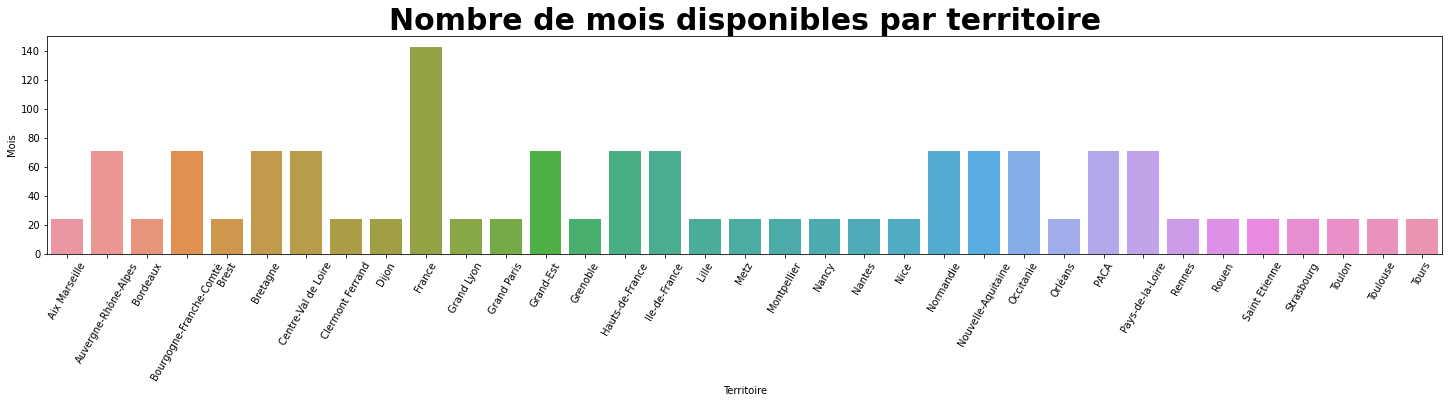

In [9]:
plt.figure(figsize=(25, 4))
sns.barplot(x = data_territoire.index, y= data_territoire['Mois'])
plt.title('Nombre de mois disponibles par territoire', fontdict = {'fontsize': '30', 'fontweight' : 'bold'})
plt.xticks(rotation ='60')
plt.savefig('graphiques/P9_02_nb_mois_territoire.png')
plt.show()

On choisi de ne garder que les <b>données nationales</b> car nous ne disposons pas d'autant de données au niveau régional.

In [10]:
list_territoire = data_territoire[data_territoire['Mois']> 70].index.values
data = data[data['Territoire'].isin(list_territoire)]

## Importation des donnés concernant les degrés jours unifiés

Données issues d'un simulateur de calcul du DJU sur le sitecegibat.grdf.fr

In [11]:
def get_local_dju(list_territoire, data):
    data_dju = data.copy()
    for t in list_territoire :
        territoire = t
        url = "data/dju - " + territoire + ".csv"
        if t != 'France':
            dju = pd.read_csv(url)
            url = "data/dju - " + territoire + ".csv"
            dju = pd.read_csv(url)
            for index,row in dju.iterrows():
                for i in range(12):
                    if i < 9 :
                        mois = mois = str(row[0]) + "-0" + str(i+1)
                    else :
                        mois = mois = str(row[0]) + "-" + str(i+1)
                    dju_value = row[i+1]
                    dju_value = dju_value.replace(',','.')
                    data_dju.loc[(data_dju['Territoire'].str.match(territoire)) & (data_dju['Mois'].str.match(mois)), 'Dju'] = float(dju_value)
    return data_dju

def get_dju(list_territoire, data) :
    data = get_local_dju(list_territoire, data)
    data_france = data[data['Dju'].notna()]
    data_france = data_france.groupby('Mois').mean()
    data_france = data_france[['Dju']]
    for index, row in data_france.iterrows():
        data.loc[(data['Territoire'].str.match('France')) & (data['Mois'].str.match(index)), 'Dju'] = row[0]
    return data

In [12]:
data = get_dju(list_territoire, data)

## Choix des variables pertinentes

In [13]:
data.drop(['Qualité', 'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre', 'Eolien offshore'], axis = 1, inplace = True)

## Gestion des valeurs nulles

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 1522
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      995 non-null    object 
 1   Territoire                                995 non-null    object 
 2   Production totale                         959 non-null    float64
 3   Production nucléaire                      628 non-null    float64
 4   Production thermique totale               959 non-null    float64
 5   Production thermique charbon              473 non-null    float64
 6   Production thermique fioul                671 non-null    float64
 7   Production thermique gaz                  671 non-null    float64
 8   Production hydraulique                    959 non-null    float64
 9   Production éolien                         959 non-null    float64
 10  Production solaire                   

## France

In [15]:
data_france = data[data['Territoire'].str.match('France')]

## Consommation totale

On visualise l'évolution de la consommation totale d'énergie en France.

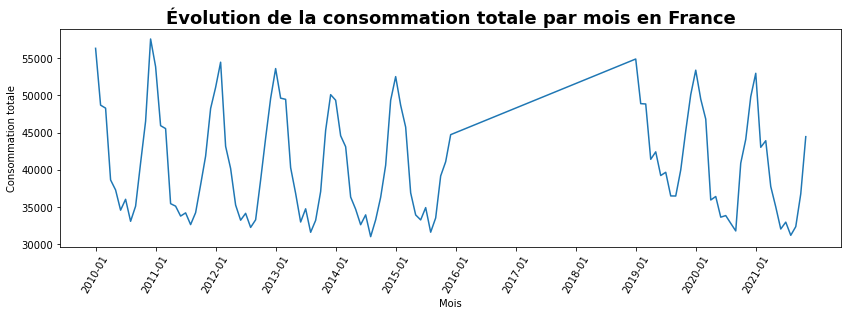

In [16]:
plt.figure(figsize=(14, 4))
sns.lineplot(x = data_france['Mois'], y = data_france['Consommation totale'])
plt.title('Évolution de la consommation totale par mois en France', fontdict = {'fontsize': '18', 'fontweight' : 'bold'})
plt.xticks(np.arange(0, len(data_france['Mois'])+1, 12), rotation ='60')
plt.savefig('graphiques/P9_03_evolution_conso_totale.png')
plt.show()

On remarque l'absence de données pour les années <b><span style="color:red">2016, 2017</span> et <span style="color:red">2018</span></b>.<p>
Nous choisirons de travailler que sur les données <b><span style="color:green">pré 2016</span></b> dans un premier temps puis <span style="color:green">post 2018</span> pour ce qui concerne les prédictions car elles sont plus récentes

## Dégrés jours unifiés

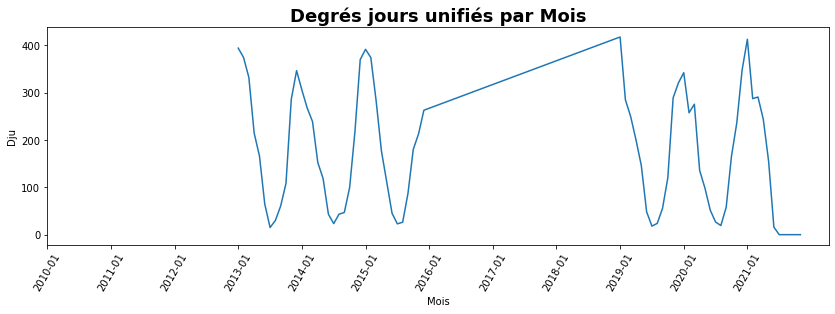

In [17]:
plt.figure(figsize=(14, 4))
sns.lineplot(x = data_france['Mois'], y= data_france['Dju'])
plt.title('Degrés jours unifiés par Mois', fontdict = {'fontsize': '18', 'fontweight' : 'bold'})
plt.xticks(np.arange(0, len(data_france['Mois'])+1, 12), rotation ='60')
plt.savefig('graphiques/P9_04_evolution_dju.png')
plt.show()

# Test de normalité des distributions

In [18]:
data_france_train = data_france.copy()
data_france_train['Mois'] = pd.to_datetime(data_france_train['Mois'], format='%Y%m%')
data_france_train = data_france_train.set_index('Mois')
data_france_train = data_france_train[['Consommation totale', 'Dju']]
data_france_test = data_france_train.copy()
data_france_train = data_france_train[(data_france_train.index < '2016-01')]
data_france_test = data_france_test[(data_france_test.index > '2018-12')]

In [19]:
data_france_train.rename({'Consommation totale': 'conso_totale'}, axis = 1, inplace = True)
data_france_test.rename({'Consommation totale': 'conso_totale'}, axis = 1, inplace = True)

In [20]:
len(data_france_train), len(data_france_test)

(72, 35)

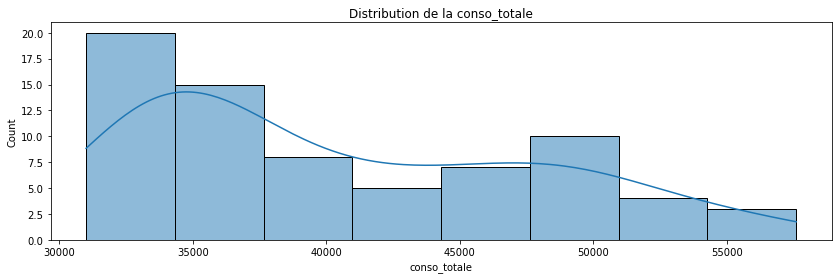

In [21]:
plt.figure(figsize=(14, 4))
sns.histplot(data_france_train['conso_totale'], kde = True )
plt.title('Distribution de la conso_totale')
plt.savefig('graphiques/P9_05_normalite_conso_totale.png')
plt.show()

In [22]:
norm = shapiro(data_france_train['conso_totale'])
if norm[1] > 0.05 :
    print("L'hypothèse de normalité est acceptée") 
else :
    print("L'hypothèse de normalité est rejetée")

L'hypothèse de normalité est rejetée


# Représentation des séries temporelles

In [23]:
x = data_france_train
y = np.log(x)

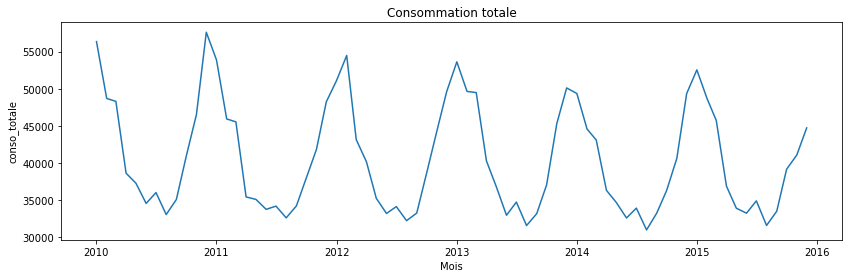

In [24]:
plt.figure(figsize=(14, 4))
sns.lineplot( x = data_france_train.index, y = x['conso_totale']).set(title='Consommation totale')
plt.savefig('graphiques/P9_06_evolution_conso_totale_2010_2015.png')
plt.show()

On peut voir que notre série temporelle semble sujette à un phénomène de <b>saisonalité</b> d'une durée de <b>12</b> mois .

# Comsommation corrigée de l'effet de température

On visualise les données

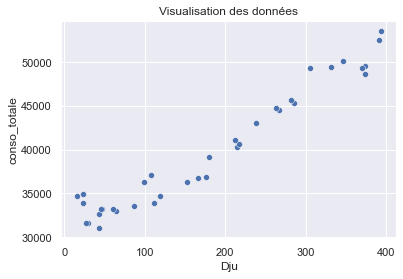

In [25]:
sns.set()
ax = sns.scatterplot(x="Dju", y="conso_totale", data=x)
ax.set(xlabel='Dju', ylabel='conso_totale')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.title('Visualisation des données')
plt.savefig('graphiques/P9_07_visualisation_conso_totale_dju.png')
plt.show()

Il semble y avoir forte corrélation linéaire entre la consommation totale d'énergie et les degrés de jour unifiés. <p>
On confirme par un test de Pearson.

In [26]:
x['conso_totale'].corr(x['Dju'], method= 'pearson')

0.9728260284618014

In [27]:
res = smf.ols('conso_totale~Dju', data = x).fit()

In [28]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           conso_totale   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     600.2
Date:                Tue, 19 Jul 2022   Prob (F-statistic):           3.48e-23
Time:                        12:18:21   Log-Likelihood:                -316.58
No. Observations:                  36   AIC:                             637.2
Df Residuals:                      34   BIC:                             640.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.024e+04    479.485     63.076      0.0

Notre modèle possède un <b>coefficient de détermination de <span style="color:red">0.946</span></b> <br />
Le modèle est significatif ainsi que le paramètre Dju. <br />
<b>p-value de Dju < 0.05 </b>.

On vient confirmer cette corrélation linéaire avec un graphique de droite de régression.

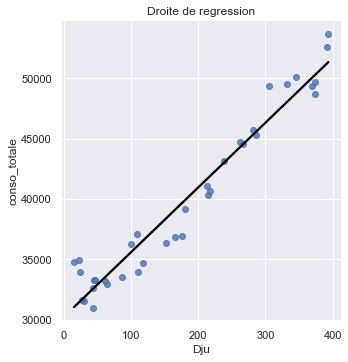

In [29]:
fig = sns.set(rc = {'figure.figsize':(14,4)})
ax = sns.lmplot(x="Dju", y="conso_totale", data=x, ci=None, line_kws={'color':'black'})
ax.set(xlabel='Dju', ylabel='conso_totale')
plt.title('Droite de regression')
plt.savefig('graphiques/P9_08_droite_regression_conso_totale_dju.png')
plt.show()

## Analyse des résidus

In [30]:
shapiro(res.resid)

ShapiroResult(statistic=0.968406617641449, pvalue=0.3836289942264557)

L'hypothèse nulle de normalité des résidus semble ne semble pas pouvoir être rejetée. <p>
On confirme par une représentation graphique de la distribution des résidus.

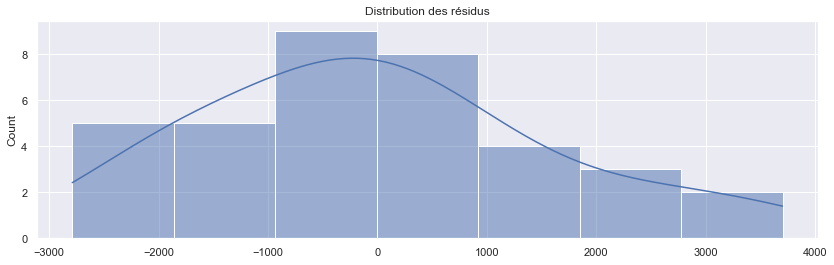

In [31]:
plt.figure(figsize=(14, 4))
sns.histplot(res.resid, kde = True )
plt.title('Distribution des résidus')
plt.savefig('graphiques/P9_09_normalite_res_regression_conso_totale_dju.png')
plt.show()

## Correction des données 

On vient corriger notre consommation d'énergie des degré Unifiés jour.<p>
<font size=5>Y = Y - alpha * X</font><br>

In [32]:
x['conso_totale_corrigée'] = x['conso_totale'] - (res.params[1] * x['Dju'])

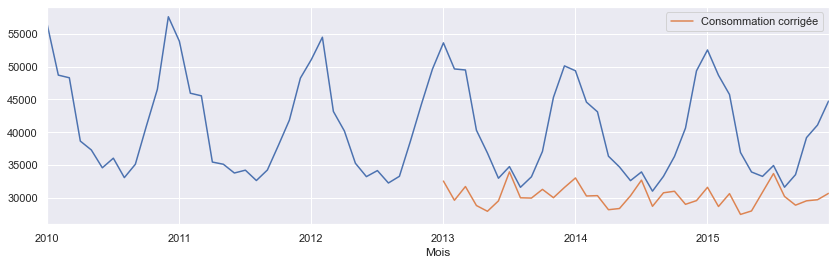

In [33]:
conso_totale = x['conso_totale'].rename('Consommation totale')
conso_corr = x['conso_totale_corrigée'].rename('Consommation corrigée')
conso_totale.plot(figsize=(14,4))
conso_corr.plot(legend = True)
plt.savefig('graphiques/P9_10_conso_totale_corrigee.png')
plt.show()

On peut voir que notre consommation corrigée semble désaisonnalisée.

In [34]:
x = data_france_train[['conso_totale']]
y = np.log(x)

# Désaisonnalisation à l'aide de la régression linéaire

On va travailler à partir de la série temporelle représentant la <b>consommation d'énergie</b> à l'échelle <b>logarithmique</b> afin que notre modèle soit <b>additif</b>.<p>
    On crée les bases tendancielles et saisonnières.

In [35]:
t = range(1, 73)

for i in range(12):
    su = np.repeat(0, repeats=12)
    su[i] = 1
    s = np.tile(su, 72 // len(su) + 1)[:72]
    vars()['s' + str(i+1)] = s

On effectue notre régression linéaire en faisant attention de palier au problème de colinéarité sur notre série.

In [36]:
from sklearn import linear_model

reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(np.array([t, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12]).transpose(), y)

LinearRegression(fit_intercept=False)

In [37]:
a = np.mean(reg.coef_[0][1:13])
b = reg.coef_[0][0]
c = reg.coef_[0][1:13] - a

On desaisonnalise notre série temporelle originale en soustrayant la moyenne des coefficients de corrélation * coefficient de corréation à chaque valeurs

In [38]:
y_cvs = y['conso_totale'] - (c[0]*s1+c[1]*s2+c[2]*s3+c[3]*s4+c[4]*s5+c[5]*s6+c[6]*s7+c[7]*s8+c[8]*s9+
                        c[9]*s10+c[10]*s11+c[11]*s12)
x_cvs_linear = np.exp(y_cvs)

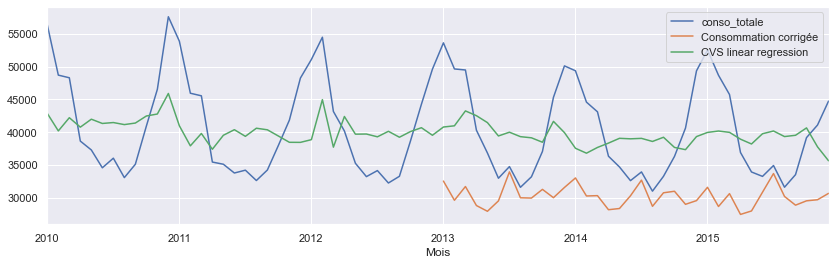

In [39]:
x_cvs_linear = x_cvs_linear.rename("CVS linear regression")
x.plot(figsize=(14,4))
conso_corr.plot(legend = True)
x_cvs_linear.plot(legend = True)
plt.savefig('graphiques/P9_11_desaissonalisation_regression_lineaire.png')
plt.show()

On peut voir que nous avons pu désaisonnaliser notre série gràce à la régression linéaire.<br />
Notre série corrigée semble moins précise que notre série désaisonnalisée.

# Désaisonnalisation à l'aide des moyennes mobiles

La fonction <font size=3>seasonal_decompose()</font>

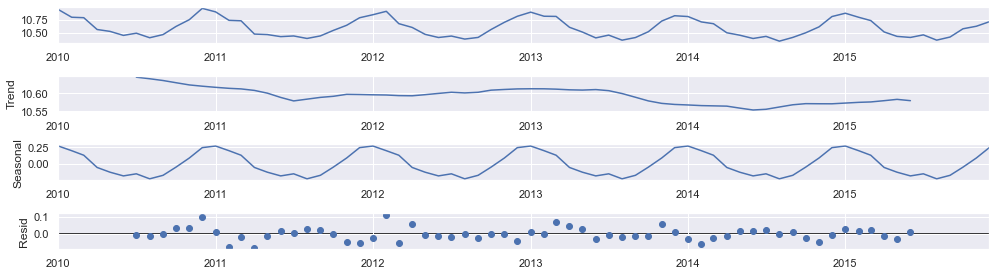

In [40]:
decomp_y = seasonal_decompose(y,  model='additive', period = 12)
decomp_y.plot()
plt.savefig('graphiques/P9_12_seasonal_decompose.png')
plt.show()

Il nous suffit ici de soustraire nos valeurs saisonnières à nos valeurs initiales puis de repasser nos valeurs à l'échelle de base. <p>

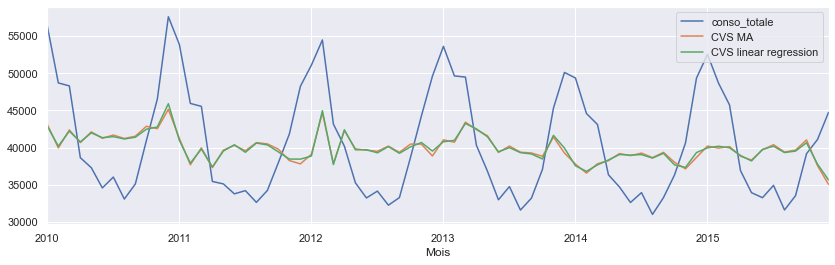

In [41]:
x_cvs = np.exp(decomp_y.observed - decomp_y.seasonal)
x_cvs = x_cvs.rename("CVS MA")
x.plot(figsize=(14,4))
x_cvs.plot(legend = True)
x_cvs_linear.plot(legend = True)
plt.savefig('graphiques/P9_13_desaisonnalisation_ma.png')
plt.show()

On peut voir sur le graphique que les 2 méthodes permettent efficacement de desaisonnaliser notre série temporelle.

# Prédictions via la méthode Holt-Winters 

In [42]:
hw = ExponentialSmoothing(np.asarray(y['conso_totale']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

La méthode Holt-Winters est une méthode de lissage exponentiel qui, contrairement aux autres méthodes de lissage exponentiel, prend en compte la saisonnalité.

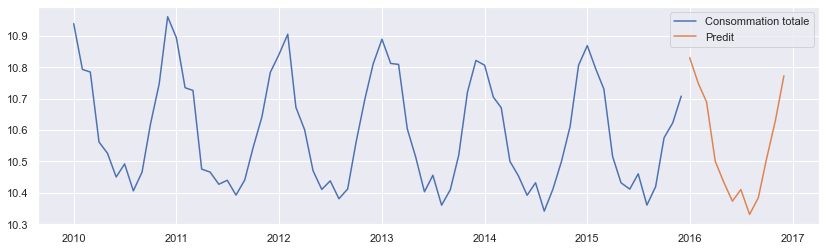

In [43]:
plt.figure(figsize=(14, 4))
plt.plot(y['conso_totale'], label='Consommation totale')
plt.plot(pd.date_range(y.index[len(y['conso_totale'])-1], periods=12, freq='M'), hw_pred, label='Predit')
plt.legend()
plt.savefig('graphiques/P9_14_predictions_holt_winters.png')
plt.show()

# Prédictions via la méthode SARIMA

<font size=5><b>SARIMA</b></font> : Seasonnal Auto Regression Integrated Moving Average permet de modéliser la consommation d'énergie totale même si celle-ci présente une saisonnalité.

In [44]:
def plot_sortie_acf( x_acf, x_len, pacf=False, title=''):
    "représentation de la sortie ACF"
    if pacf:
        x_acf = x_acf[1:]
    plt.figure(figsize=(14,6))
    plt.bar(range(len(x_acf)), x_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(x_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(x_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.title(title)
    plt.savefig('graphiques/P9_15_ACF'+title+'.png')
    plt.show()
    return

## Stationnarisation de la consommation d'énergie

On visualise la sortie ACF de la consommation d'énergie.<br />
La sortie ACF permet de détecter des régularités ou des profils répétes.<br/>
Dans le cadre de la modélisation ARMA on va travailler sur une série additive, on utilisera donc notre série à l'échelle logarithmique.

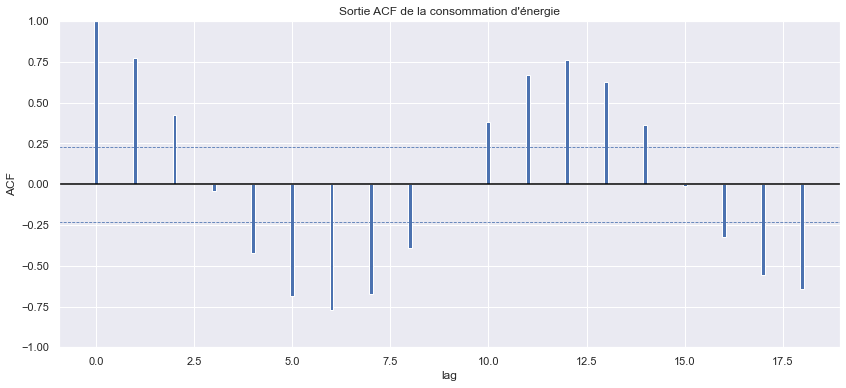

In [45]:
y_len = len(y['conso_totale']) # variable nécessaire pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y['conso_totale'])), y_len, title="Sortie ACF de la consommation d'énergie")

L'autocorrélogramme décroit trop lentement vers 0, il n'est pas possible que ce soit l'estimation d'un autocorrélogramme simple qui aurait pu être modélisé par un modèle linéaire ARMA (Auto Regressive Moving Average).<br />
On a donc un problème de non stationnarité. <br />
On va utiliser la différenciation.

##### Différenciation  ( I - B )

On élimine donc dans un premier temps la tendance de la série en utilisant la différenciation (I-B)

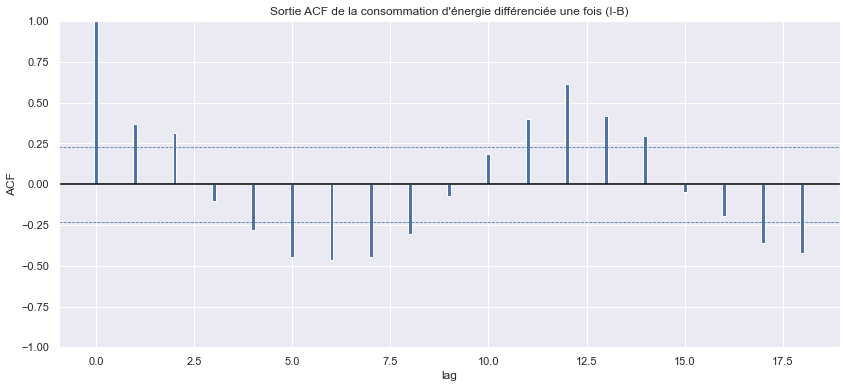

In [46]:
y_dif1 = y['conso_totale'] - y['conso_totale'].shift(1)
plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len, title="Sortie ACF de la consommation d'énergie différenciée une fois (I-B)")

On a une décroissance assez rapide vers 0 sauf pour les multiples de 12.<br />
Nous ne donc toujours pas devant un corrélogramme simple estimé.<br />
On va donc utiliser une differenciation d'ordre 12

##### Différenciation  ( I - B <sup>12</sup> )

Enfin on élimine la saisonnalité de la série différenciée (I-B) via une différenciation  ( I - B <sup>12</sup> )

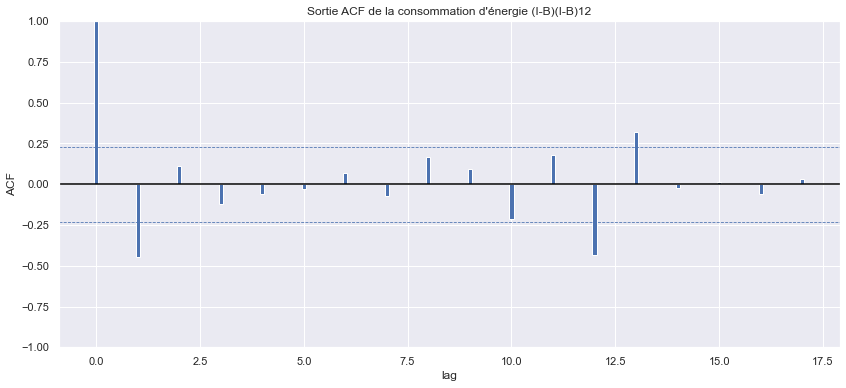

In [47]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12)
plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len, title="Sortie ACF de la consommation d'énergie (I-B)(I-B)12" )

On observe maintenant une décroissance rapide vers 0 pour toutes les valeurs de notre sortie ACF.<br />
On peut donc émettre l'hypothèse que notre série temporelle différenciée (I-B)(I-B<sup>12</sup>) est maintenant potentiellement stationnaire ce qui nous permet l'utilisation d'un model ARMA

## Identification et validation des modèles

### Autocorrelogrammes simple et partiels estimés

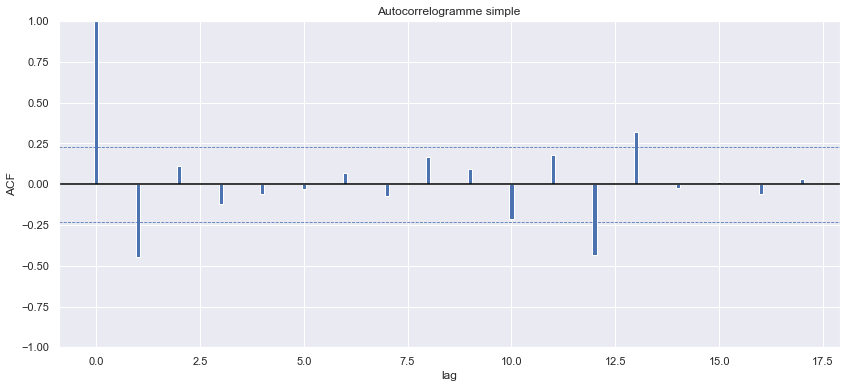

In [48]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12)
plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len, title= 'Autocorrelogramme simple')

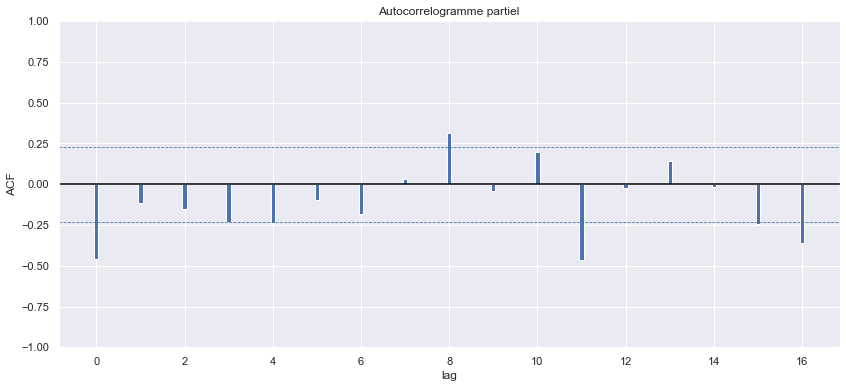

In [49]:
plot_sortie_acf(pacf(np.asarray(y_dif_1_12[13:])), y_len, pacf=True, title= 'Autocorrelogramme partiel')

On utilisera potentiellement un premier modèle SARIMA (1,1,1)(1,1,1,12)

### 1ère itération de modèle

In [50]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(y['conso_totale']), order=(1,1,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()
print(results1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  91.191
Date:                            Tue, 19 Jul 2022   AIC                           -172.381
Time:                                    12:18:25   BIC                           -161.994
Sample:                                         0   HQIC                          -168.327
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2594      0.128      2.031      0.042       0.009       0.510
ma.L1         -0.9792      0.476   

La p-value de ar.S.L12 et ma.S.L12 est > 5% le modèle n'est donc pas significatif.

### 2ème itération de modèle

On enlève le paramètre le moins significatif, le coefficient saisonnier de moyenne mobile d'ordre 12

In [51]:
model2 = SARIMAX(np.asarray(y['conso_totale']), order=(1,1,1), seasonal_order=(1,1,0,12))
results2 = model2.fit()
print(results2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                  84.172
Date:                             Tue, 19 Jul 2022   AIC                           -160.345
Time:                                     12:18:25   BIC                           -152.035
Sample:                                          0   HQIC                          -157.101
                                              - 72                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2836      0.133      2.130      0.033       0.023       0.545
ma.L1         -0.9937      

La p-value de  ma.L1 est > 5% le modèle n'est donc pas significatif.

### 3ème itération de modèle

On enlève le paramètre le moins significatif, le coefficient  coefficient saisonnier de moyenne mobile d'ordre 1

In [52]:
model3 = SARIMAX(np.asarray(y['conso_totale']), order=(1,1,0), seasonal_order=(1,1,0,12))
results3 = model3.fit()
print(results3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  79.059
Date:                            Tue, 19 Jul 2022   AIC                           -152.117
Time:                                    12:18:25   BIC                           -145.885
Sample:                                         0   HQIC                          -149.684
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4218      0.089     -4.748      0.000      -0.596      -0.248
ar.S.L12      -0.4377      0.129   

La p-value de ar.L1 et ar.S.12 est < 5% <b>le modèle est donc significatif</b>.<br />
On va vérifier que le test de blancheur n'est pas rejeté.

## Analyse des résidus

### Test de blancheur

In [53]:
print('Retard : p-value')
for elt in [6, 12, 18, 24, 30]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3.resid, lags=elt).values[1].mean()))

Retard : p-value
6 : 0.5043191381842813
12 : 0.5043191381842813
18 : 0.5043191381842813
24 : 0.5043191381842813
30 : 0.5043191381842813


Le test de blancheur n'est pas rejeté, il n'y a plus d'autocorrelation dans nos résidus.

### Test de normalité 

In [54]:
from scipy.stats import shapiro

shapiro(results3.resid)

ShapiroResult(statistic=0.2108590006828308, pvalue=8.877738258101908e-18)

pvalue > 5% donc l'hypothèse de normalité n'est pas rejetée pour le modèle 3.

### Graphiques

##### QQplot 

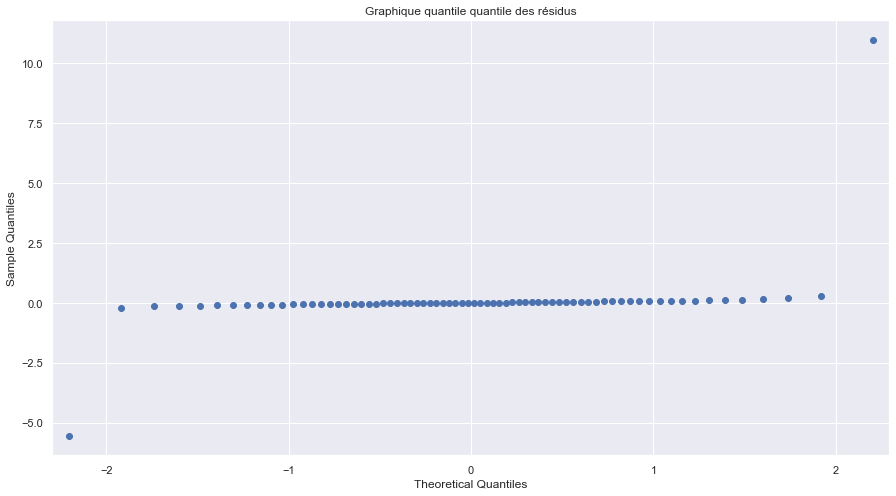

In [55]:
#On confirme par un graphique
fig = sns.set(rc = {'figure.figsize':(15,8)})
ax = sm.qqplot(results3.resid)
plt.title('Graphique quantile quantile des résidus')
plt.savefig('graphiques/P9_16_qqplot_res_sarima_3_iteration.png')
plt.show()

##### Graphique des résidus 

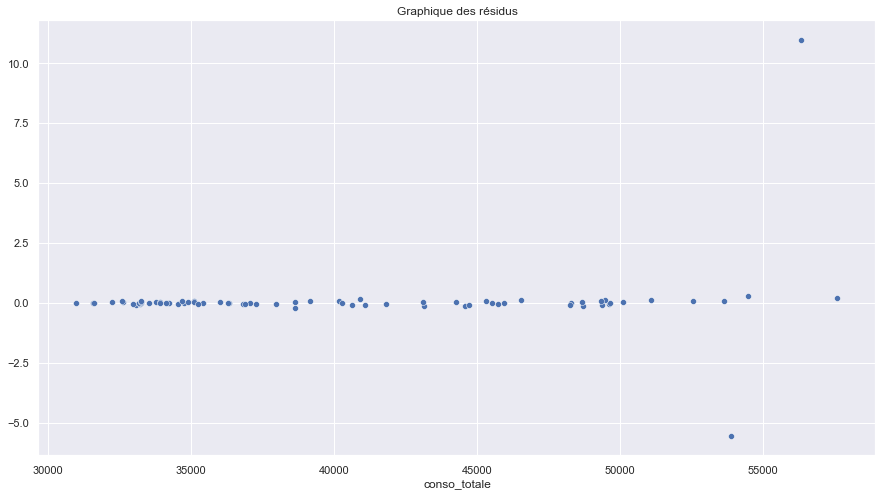

In [56]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(y = results3.resid, x = x['conso_totale']).set(title='Graphique des résidus')
plt.savefig('graphiques/P9_17_graphique_res_sarima_3_iteration.png')
plt.show()

## Prédictions

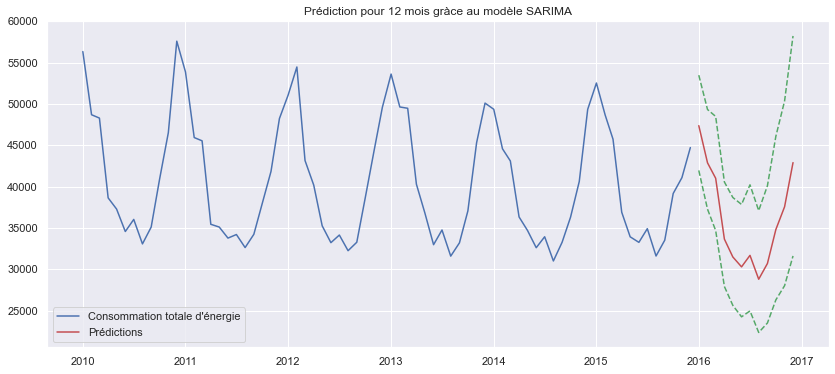

In [57]:
pred_model3 = results3.get_forecast(12)
pred = np.exp(pred_model3.predicted_mean)
pred_l = [np.exp(elt[0]) for elt in pred_model3.conf_int(alpha=0.05)]
pred_u = [np.exp(elt[1]) for elt in pred_model3.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x['conso_totale'], label="Consommation totale d'énergie")
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Prédictions')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title('Prédiction pour 12 mois gràce au modèle SARIMA')
plt.legend()
plt.savefig('graphiques/P9_18_pred_sarima_3_2016.png')
plt.show()

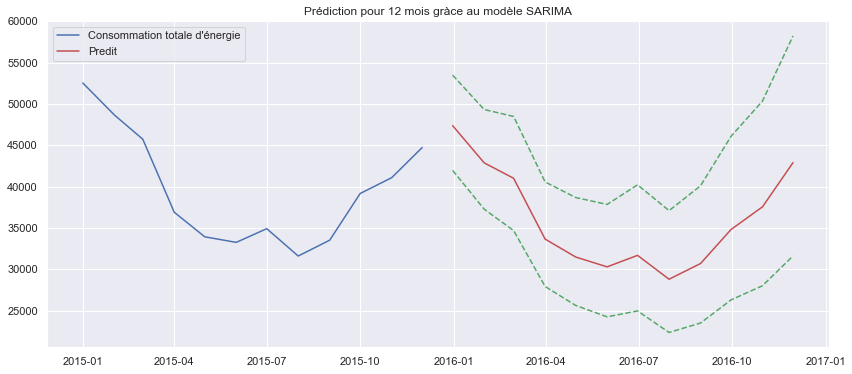

In [58]:
plt.figure(figsize=(14,6))
plt.plot(x['conso_totale']['2015':], label="Consommation totale d'énergie")
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title('Prédiction pour 12 mois gràce au modèle SARIMA')
plt.legend()
plt.savefig('graphiques/P9_19_pred_sarima_3_2016_focus.png')
plt.show()

##### Analyse a posteriori

In [59]:
x_tronc = x[:'2014']
y_tronc = np.log(x_tronc)
x_a_prevoir = x['2015':]

In [60]:
model3_tronc = SARIMAX(np.asarray(y_tronc['conso_totale']), order=(1,1,0), seasonal_order=(1,1,0,12))
results3_tronc = model3_tronc.fit()
print(results3_tronc.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  61.751
Date:                            Tue, 19 Jul 2022   AIC                           -117.501
Time:                                    12:18:26   BIC                           -111.951
Sample:                                         0   HQIC                          -115.413
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4968      0.111     -4.475      0.000      -0.714      -0.279
ar.S.L12      -0.3989      0.157   

La p-value des paramètres est < 5%, le modèle est donc significatif.<br />
On effectue un test de blancheur des résidus pour valider le modèle.

##### Test de blancheur 

In [61]:
print('Retard : p-value')
for elt in [6, 12, 18]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3_tronc.resid, lags=elt).values[1].mean()))

Retard : p-value
6 : 0.5033007199293269
12 : 0.5033007199293269
18 : 0.5033007199293269


Le test de blancheur n'est pas rejeté, il n'y a plus d'autocorrelation dans nos résidus.

In [62]:
shapiro(results3_tronc.resid)

ShapiroResult(statistic=0.2344750165939331, pvalue=4.625465342267667e-16)

Le test de normalité vient appuyer notre test de blancheur.

In [63]:
pred_model3tronc = results3_tronc.get_forecast(12)
pred_tronc = np.exp(pred_model3tronc.predicted_mean)
pred_l_tronc = [np.exp(elt[0]) for elt in pred_model3tronc.conf_int(alpha=0.05)]
pred_u_tronc = [np.exp(elt[1]) for elt in pred_model3tronc.conf_int(alpha=0.05)]

##### Prédictions à postériori

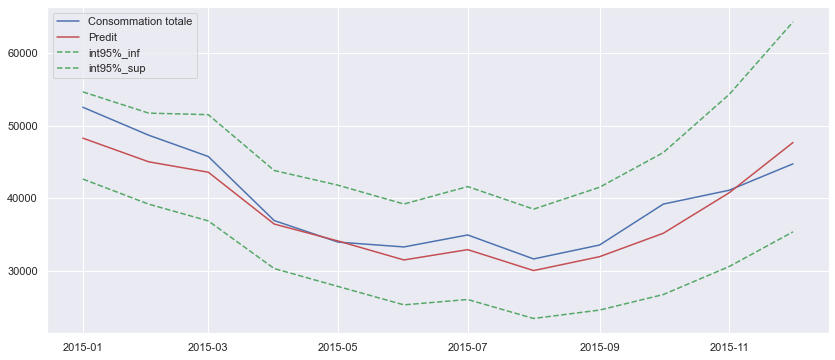

In [64]:
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation totale')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.savefig('graphiques/P9_20_pred_posteriori_sarima_2015.png')
plt.show()

##### RMSE

In [65]:
rmse = np.sqrt(((x_a_prevoir['conso_totale']-pred_tronc)**2).mean())
rmse

2485.254286691967

##### MAPE 

In [66]:
mape=(np.abs(1-pred_tronc/x_a_prevoir['conso_totale'])).mean()*100
mape

5.0794062112574

## Prédictions 2022

In [67]:
x = data_france_test['conso_totale']
y =np.log(x)

On visualise la sortie <font size=+1>ACF de la consommation d'énergie</font>.<br />
La sortie ACF permet de détecter des régularités ou des profils répétes.<br/>
Dans le cadre de la modélisation ARMA on va travailler sur une série additive, on utilisera donc notre série à l'échelle logarithmique.

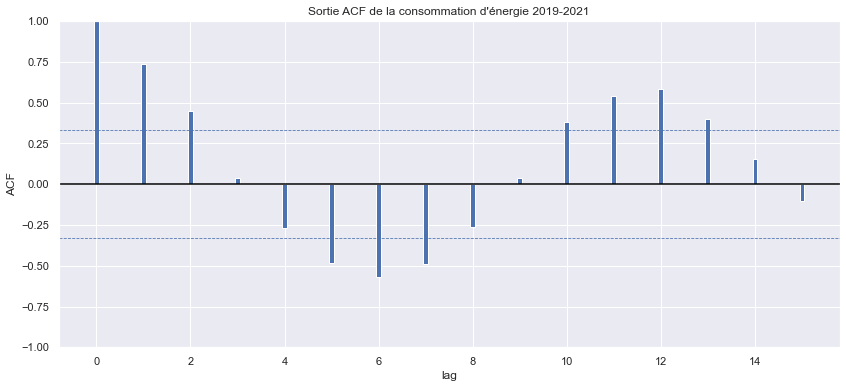

In [68]:
y_len = len(y) # variable nécessaire pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y)), y_len, title="Sortie ACF de la consommation d'énergie 2019-2021")

L'autocorrélogramme décroit trop lentement vers 0, il n'est pas possible que ce soit l'estimation d'un autocorrélogramme simple qui aurait pu être modélisé par un modèle linéaire ARMA (Auto Regressive Moving Average).<br />
On a donc un problème de non stationnarité. <br />
On va utiliser la différenciation.

##### Différenciation  ( I - B )

On élimine donc dans un premier temps la tendance de la série en utilisant la différenciation (I-B)

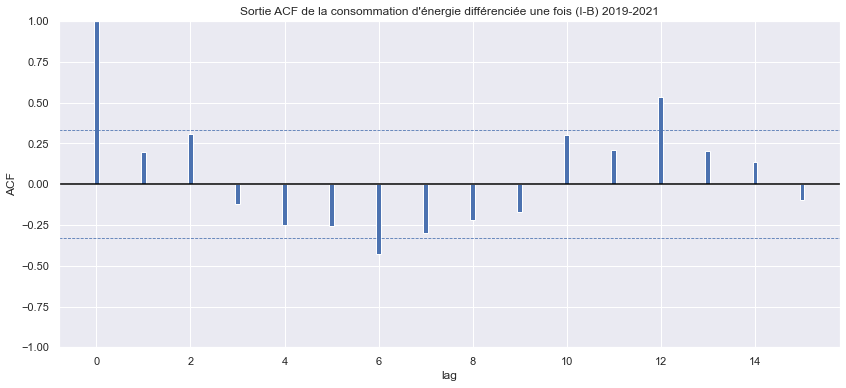

In [69]:
y_dif1 = y - y.shift(1)
plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len, title="Sortie ACF de la consommation d'énergie différenciée une fois (I-B) 2019-2021")

On a une décroissance assez rapide vers 0 sauf pour les multiples de 12.<br />
Nous ne sommes donc toujours pas devant un corrélogramme simple estimé.<br />
On va donc utiliser une differenciation d'ordre 12.

##### Différenciation  ( I - B <sup>12</sup> )

Enfin on élimine la saisonnalité de la série différenciée (I-B) via une différenciation  ( I - B <sup>12</sup> )

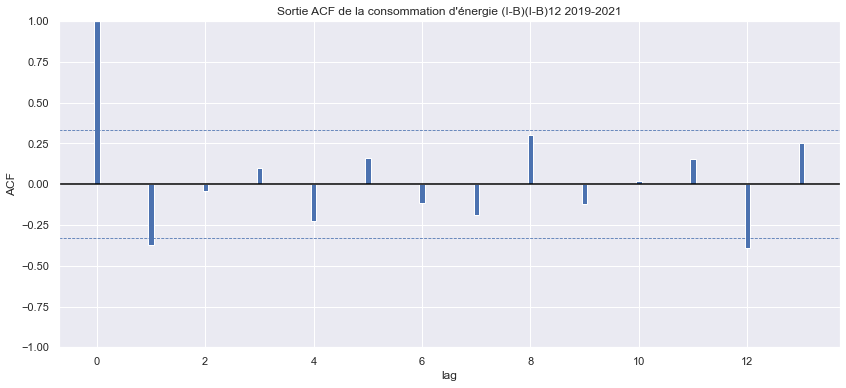

In [70]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12)
plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len, title="Sortie ACF de la consommation d'énergie (I-B)(I-B)12 2019-2021" )

On observe maintenant une décroissance rapide vers 0 pour toutes les valeurs de notre sortie ACF.<br />
On peut donc émettre l'hypothèse que notre série temporelle différenciée (I-B)(I-B<sup>12</sup>) est maintenant potentiellement stationnaire ce qui nous permet l'utilisation d'un model ARMA.

## Identification et validation des modèles

### Autocorrelogrammes simple et partiels estimés

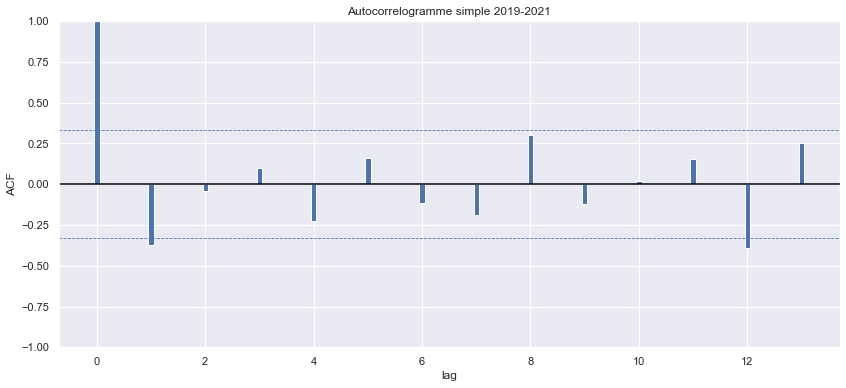

In [71]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12)
plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len, title= 'Autocorrelogramme simple 2019-2021')

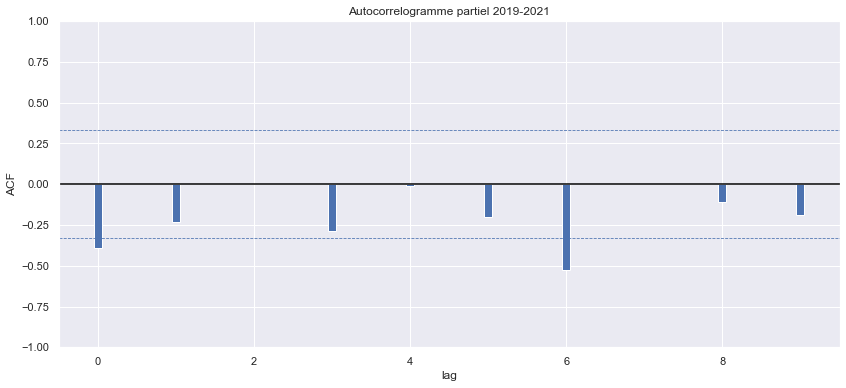

In [72]:
plot_sortie_acf(pacf(np.asarray(y_dif_1_12[13:])), y_len, pacf=True, title= 'Autocorrelogramme partiel 2019-2021')

On utilisera potentiellement un premier modèle SARIMA (1,1,1)(1,1,1,12)

##### 1ère itération 

In [73]:
model_pred = SARIMAX(np.asarray(y), order=(1,1,1), seasonal_order=(1,1,1,12))
results_2022 = model_pred.fit()
print(results_2022.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   35
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  30.917
Date:                            Tue, 19 Jul 2022   AIC                            -51.834
Time:                                    12:18:28   BIC                            -46.379
Sample:                                         0   HQIC                           -50.549
                                             - 35                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0166      1.257     -0.013      0.989      -2.479       2.446
ma.L1         -0.2541      1.333   

C:\Users\fapic\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Nos pvalue de nos paramètres est >5% le modèle n'est donc pas significatif

##### 2ème itération 

In [74]:
model_pred = SARIMAX(np.asarray(y), order=(1,1,1), seasonal_order=(0,1,1,12))
results_2022 = model_pred.fit()
print(results_2022.summary())

C:\Users\fapic\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   35
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  31.140
Date:                            Tue, 19 Jul 2022   AIC                            -54.280
Time:                                    12:18:28   BIC                            -49.916
Sample:                                         0   HQIC                           -53.252
                                             - 35                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4624      0.493      0.938      0.348      -0.504       1.429
ma.L1         -0.9719      1.662   

Nos pvalue de nos paramètres est >5% le modèle n'est donc pas significatif

##### 3ème itération

In [75]:
model_pred = SARIMAX(np.asarray(y), order=(1,1,1), seasonal_order=(0,1,0,12))
results_2022 = model_pred.fit()
print(results_2022.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   35
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                  28.650
Date:                             Tue, 19 Jul 2022   AIC                            -51.301
Time:                                     12:18:28   BIC                            -48.027
Sample:                                          0   HQIC                           -50.530
                                              - 35                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3664      0.349      1.051      0.293      -0.317       1.050
ma.L1         -0.9488      

Nos pvalue de nos paramètres est >5% le modèle n'est donc pas significatif

##### 4ème itération  

In [76]:
model_pred = SARIMAX(np.asarray(y), order=(0,1,1), seasonal_order=(0,1,0,12))
results_2022 = model_pred.fit()
print(results_2022.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   35
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                  27.965
Date:                             Tue, 19 Jul 2022   AIC                            -51.929
Time:                                     12:18:28   BIC                            -49.747
Sample:                                          0   HQIC                           -51.415
                                              - 35                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5629      0.263     -2.144      0.032      -1.078      -0.048
sigma2         0.0045      

La pvalue des paramètres est <5% ,le modèle est donc significatif. <br /> 

##### Test de blancheur

In [77]:
print('Retard : p-value')
for elt in [6, 12, 18, 24, 30]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_2022.resid, lags=elt).values[1].mean()))

Retard : p-value
6 : 0.5006623785705531
12 : 0.5006623785705531
18 : 0.5006623785705531
24 : 0.5006623785705531
30 : 0.5006623785705531


Il n'y aucune autocorrelation dans nos résidus ce qui est confirmé par le test de blancheur. <br />

In [78]:
print('Test de Shapiro-Wilk : ',shapiro(results_2022.resid))

Test de Shapiro-Wilk :  ShapiroResult(statistic=0.3148718476295471, pvalue=1.2522088400912512e-11)


Le test de Shapiro-Wilk qui semble confirmer la normalité de la distribution des résidus.

##### Prédictions pour 2022

In [79]:
pred_model_2002 = results_2022.get_forecast(12)
pred = np.exp(pred_model_2002.predicted_mean)
pred_l = [np.exp(elt[0]) for elt in pred_model_2002.conf_int(alpha=0.05)]
pred_u = [np.exp(elt[1]) for elt in pred_model_2002.conf_int(alpha=0.05)]

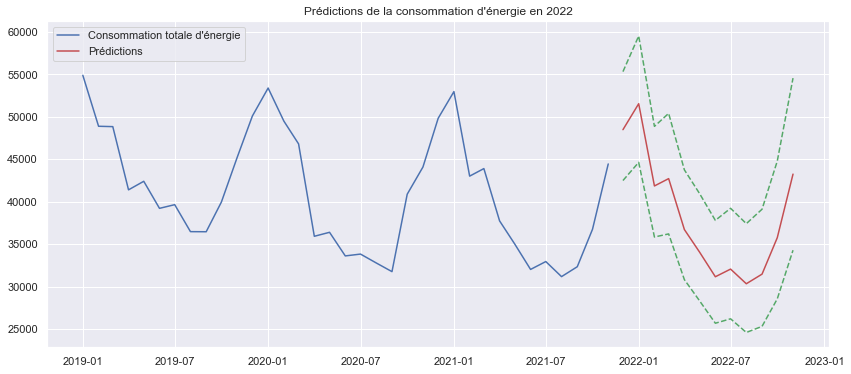

In [80]:
plt.figure(figsize=(14,6))
plt.plot(data_france_test['conso_totale'], label="Consommation totale d'énergie")
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred, color='r', label='Prédictions')
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédictions de la consommation d'énergie en 2022")
plt.legend()
plt.savefig('graphiques/P9_21_pred_sarima_2022.png')
plt.show()

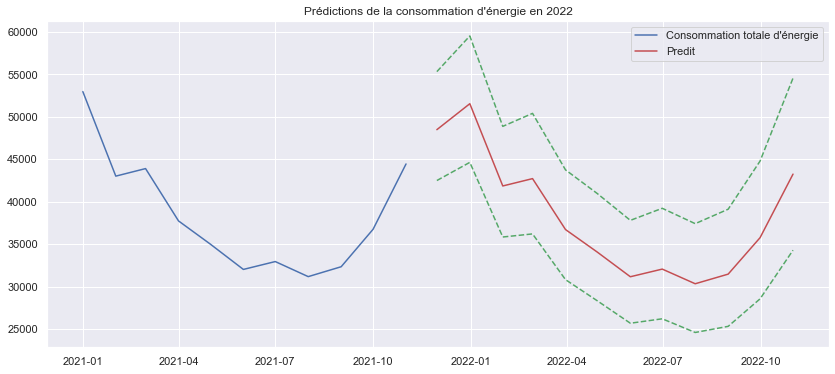

In [81]:
plt.figure(figsize=(14,6))
plt.plot(data_france_test['conso_totale']['2021':], label="Consommation totale d'énergie")
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédictions de la consommation d'énergie en 2022")
plt.legend()
plt.savefig('graphiques/P9_22_pred_sarima_2021_focus.png')
plt.show()

##### Analyse a posteriori

In [82]:
x_tronc = x[:'2020']
y_tronc = np.log(x_tronc)
x_a_prevoir = x['2021':]

In [83]:
model3_tronc = SARIMAX(np.asarray(y_tronc), order=(1,1,0), seasonal_order=(1,1,0,12))
results3_tronc = model3_tronc.fit()
print(results3_tronc.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   24
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  14.730
Date:                            Tue, 19 Jul 2022   AIC                            -23.460
Time:                                    12:18:29   BIC                            -22.267
Sample:                                         0   HQIC                           -24.213
                                             - 24                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2290      0.494     -0.463      0.643      -1.198       0.740
ar.S.L12       0.0263    192.625   

C:\Users\fapic\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


La p-value des paramètres est < 5% le modèle est donc significatif et on effectue un test de blancheur des résidus pour valider le modèle.

##### Test de blancheur

In [84]:
print('Retard : p-value')
for elt in [6, 12, 18]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3_tronc.resid, lags=elt).values[1].mean()))

Retard : p-value
6 : 0.5003904690993665
12 : 0.5003904690993665
18 : 0.5003904690993665


In [85]:
shapiro(results3_tronc.resid)

ShapiroResult(statistic=0.39015698432922363, pvalue=5.6563616013249884e-09)

In [86]:
pred_model3tronc = results3_tronc.get_forecast(11)
pred_tronc = np.exp(pred_model3tronc.predicted_mean)
pred_l_tronc = [np.exp(elt[0]) for elt in pred_model3tronc.conf_int(alpha=0.05)]
pred_u_tronc = [np.exp(elt[1]) for elt in pred_model3tronc.conf_int(alpha=0.05)]

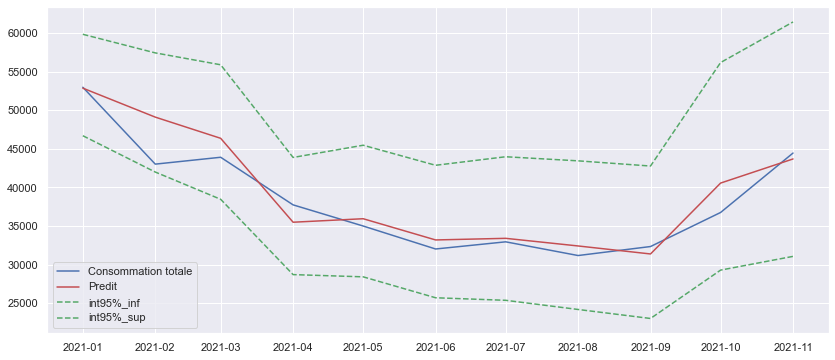

In [87]:
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation totale')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.savefig('graphiques/P9_23_pred_posteriori_sarima_2021.png')
plt.show()

##### RMSE

In [88]:
rmse = np.sqrt(((x_a_prevoir-pred_tronc)**2).mean())
rmse

2489.992086930735

##### MAPE 

In [89]:
mape=(np.abs(1-pred_tronc/x_a_prevoir)).mean()*100
mape

4.7893024803179935

In [90]:
hw = ExponentialSmoothing(np.asarray(data_france_test['conso_totale']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

C:\Users\fapic\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


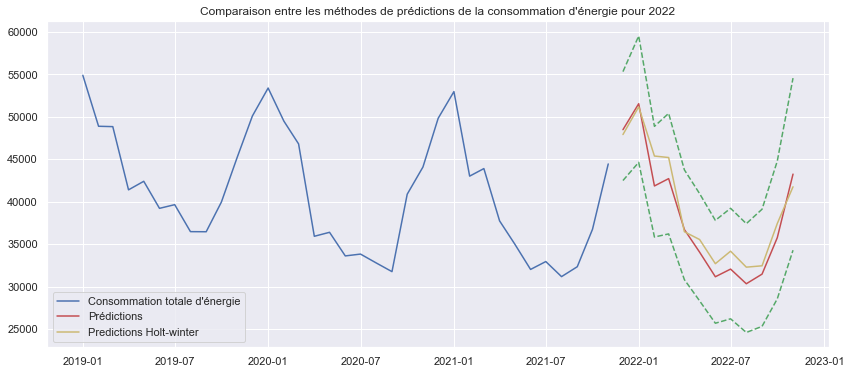

In [91]:
plt.figure(figsize=(14,6))
plt.plot(data_france_test['conso_totale'], label="Consommation totale d'énergie")
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred, color='r', label='Prédictions')
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(data_france_test.index[len(data_france_test)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.plot(pd.date_range(y.index[len(data_france_test['conso_totale'])-1], periods=12, freq='M'), hw_pred, color='y', label='Predictions Holt-winter')
plt.title("Comparaison entre les méthodes de prédictions de la consommation d'énergie pour 2022")
plt.legend()
plt.savefig('graphiques/P9_20_pred_sarima_vs_holt_winters_2022.png')
plt.show()

Les méthodes de prédictions semblent pertinentes mais la méthodologie qui accompagne le modèle SARIMA prend en compte plus de paramètre ce qui permet d'affiner notre analyse et notre prédiction ainsi que de s'assurer que toute l'information est prise en compte.